In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from os import listdir
import re

### Retrieve data files list

In [2]:
folder = 'data/'
# get all file names
files = [f for f in listdir(folder) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{folder}{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3
n = len(files)

### Read in data

In [3]:
y = np.zeros(shape=n,dtype=int)
X = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    y[i] = re.search('^([0-9]*)_',files[i])[1]
    # get the pixels, remove the alpha if needed and convert to 0-255
    X[i] = (mpimg.imread(f'{folder}{files[i]}')[:,:,:shape[2]] )
    
# transform y to label encoded
temp = y.copy()
y = np.zeros(shape=(n,12),dtype=int)
for i in range(n):
    y[i,temp[i]-1] = 1   

### Split data to training and test sets

In [4]:
# note, the input files are already shuffled
train = 0.8
cutoff = int(len(X) * train)


# reorder channel for torch
X_train = np.moveaxis(X[:cutoff],3,1)
y_train = y[:cutoff]

X_test = np.moveaxis(X[cutoff:],3,1)
y_test = y[cutoff:]

### Observe one sample

80
[0 0 0 0 0 1 0 0 0 0 0 0]


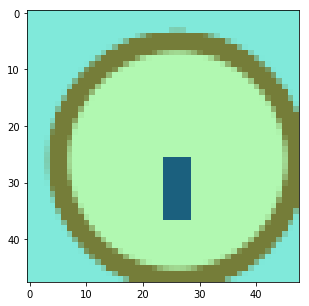

In [5]:
i = np.random.randint(0,n)
print(i)
print(y[i])
plt.figure(figsize=(5,5))
plt.imshow(X[i])
plt.show()

### Network

In [6]:
import torch

In [7]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # get number of neurons after flatten
        self.flat = self.get_flat(X_train[0].shape)
        self.fc1=torch.nn.Linear(self.flat,256)
        self.dropout=torch.nn.Dropout(p=0.5)
        self.output=torch.nn.Linear(256,12)
            
    def forward(self,X):
        relu = torch.nn.functional.relu
        x = relu(self.conv1(X))
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, self.flat)
        x = relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        x = torch.nn.functional.softmax(x,dim=1)
        return x
    
    def get_flat(self, input_shape):
        x = torch.autograd.Variable(torch.rand(1, *input_shape))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x.data.view(1, -1).size(1)        

In [ ]:
model = Model()
optimizer = torch.optim.Adam(model.parameters())

epochs = 20
batches = 50
batch_size = len(X_train)//batches

for epoch in range(epochs):
    for b in range(batches):
        # get batch
        batch = X_train[b*batch_size:(b+1)*batch_size]
        batch = torch.autograd.Variable(torch.Tensor(batch))
        y_b = torch.autograd.Variable(torch.Tensor(y_train[b*batch_size:(b+1)*batch_size]))
        # prepare optimizer
        optimizer.zero_grad()
        # get output
        outputs = model(batch)
        # calculate loss and do backprop
        loss = torch.nn.functional.smooth_l1_loss(outputs,y_b)
        loss.backward()
        optimizer.step()
    print('Epoch:' + str(epoch+1) + ', loss:' + str(float(loss)))

Epoch:1, loss:0.03833162412047386
Epoch:2, loss:0.03831718489527702
Epoch:3, loss:0.03748656436800957
Epoch:4, loss:0.038292232900857925
Epoch:5, loss:0.03448263183236122
Epoch:6, loss:0.026417924091219902
Epoch:7, loss:0.0020902103278785944


### Check accuracy

In [ ]:
pred = model(torch.autograd.Variable(torch.Tensor(X_test)))
(pred == y_test).mean()